In [1]:
#!/usr/bin/env python3
'''
Based on the work done in 
On-Manifold Preintegration for Real-Time Visual-Inertial Odometry (Carlone et al.),
and Vision-Based Control of Multirotor Systems (yet to be published)
'''

import numpy as np
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.core.debugger import Pdb

def skew(v):
    return np.array([[0, -v[2], v[1]],
                    [v[2], 0, -v[0]],
                    [-v[1], v[0], 0]])
def vee(R):
    return np.array([R[2,1], R[0,2], R[1,0]])

In [2]:
class IMU:
    def __init__(self):
        self.ba = np.zeros(3) #Leave as zeros for now
        self.bw = np.zeros(3)
        self.covar_a = np.diag([0.00561, 0.00561, 0.00561]) #from quadsim
        self.covar_w = np.diag([0.00025, 0.00025, 0.00025]) #from quadsim
    
    def getMeas(self, a_nom, w_nom):
        noise_a = np.random.multivariate_normal(np.zeros(3), self.covar_a)
        noise_w = np.random.multivariate_normal(np.zeros(3), self.covar_w)
        a = a_nom + self.ba + noise_a
        w = w_nom + self.bw + noise_w
        
        return a, w

In [3]:
class State:
    def __init__(self, p=np.zeros(3), v=np.zeros(3), R=np.eye(3), w=np.zeros(3)):
        self.p_i = p
        self.v_i = v
        self.Ri_from_b = R
        self.w_b = w
    
    def __mul__(self, dt):
        self.p_i = self.p_i * dt
        self.v_i = self.v_i * dt
        self.Ri_from_b = self.Ri_from_b * dt
        self.w_b = self.w_b * dt #Note that this isn't alpha. It is still omega
        
        return self
    
    def __rmul__(self, val):
        return self * val
    
    def __add__(self, dx):
        self.p_i = self.p_i + dx.p_i
        self.v_i = self.v_i + dx.v_i
        self.Ri_from_b = self.Ri_from_b @ expm(skew(dx.w_b))
        
        return self
    
    def __sub__(self, state2):
        dp = (self.p_i - state2.p_i)
        dv = (self.v_i - state2.v_i)
        dR = self.Ri_from_b.T @ state2.Ri_from_b
        
        return State(dp, dv, dR)
    
    def reset(self):
        self.p_i = np.zeros(3)
        self.v_i = np.zeros(3)
        self.Ri_from_b = np.eye(3)
        self.w_b = np.zeros(3)
    
    def normalize(self): #Graham Schmidt orthonormalization of rotation matrix
        x = self.Ri_from_b[:,0] / np.linalg.norm(self.Ri_from_b[:,0])
        y = skew(self.Ri_from_b[:,2]) @ x
        y = y / np.linalg.norm(y)
        z = skew(x) @ y
        z = z/np.linalg.norm(z)
        self.Ri_from_b = np.array([[*x], [*y], [*z]]).T
    
    def preIntegrate(self, a, w, dt):
        Rik = self.Ri_from_b.copy()
        v_ik = self.v_i.copy()
        self.Ri_from_b = self.Ri_from_b @ expm(skew(w) * dt)
#         self.v_i += self.Ri_from_b @ a * dt
#         self.p_i += self.v_i * dt + (dt**2)/2 * self.Ri_from_b @ a
        self.v_i += Rik @ a * dt
        self.p_i += v_ik * dt + (dt**2)/2 * Rik @ a

In [4]:
class Multirotor:
    def __init__(self, m, J):
        self.m = m
        self.J = J
        self.g = 9.81
        
        # Define states for the multirotor
        self.state = State()
    
    def dynamics(self, state, a_b, w_b):
        v_i = state.v_i
        Ri_from_b = state.Ri_from_b
        e3 = np.array([0, 0, 1])
        
        state_dot = State()
        state_dot.p_i = v_i
        state_dot.v_i = self.g * e3 + Ri_from_b @ a_b
        state_dot.Ri_from_b = Ri_from_b @ skew(w_b)
        state_dot.w_b = w_b #Not the derivative but this will be used in the integration
        
        return state_dot
    
    def update(self, a, w, dt):
#         k1 = self.dynamics(self.state, u)
#         k2 = self.dynamics(self.state + k1 * (dt/2), u)
#         k3 = self.dynamics(self.state + k2 * (dt/2), u)
#         k4 = self.dynamics(self.state + k3 * dt, u)
        
#         self.state = self.state + (dt/6) * (k1 + 2 * k2 + 2*k3 + k4)
        dx = self.dynamics(self.state, a, w)
        self.state = self.state + dt * dx
        return self.state


In [5]:
mass = 2.856
J = np.diag([.07, .08, .12])

quad = Multirotor(mass, J)
#Test to see if dynamics work
for i in range(100):
    a = np.array([1, 0, 1])
    w = np.array([.1, 0.0, .1])
    dt = .01
    temp = quad.update(a, w, dt)
    if not np.linalg.det(temp.Ri_from_b) == 1.0:
        quad.state.normalize()
print(temp.p_i)
print(temp.v_i)
print(temp.Ri_from_b)
print(np.linalg.det(temp.Ri_from_b))

def getAccel(t):
    T = 5
    A = 0.1
    ax = A * np.cos(2 * np.pi/T * t)
    ay = A * np.sin(2 * np.pi/T * t)
    az = A * np.cos(2 * np.pi/T * t - np.pi/4)
    return np.array([ax, ay, az])

def getGyro(t):
    T = 5
    A = 0.1
    wx = A * np.cos(2 * np.pi/T * t)
    wy = A * np.sin(2 * np.pi/T * t)
    wz = A * np.sin(2 * np.pi/T * t - np.pi/4)
    return np.array([wx, wy, wz])

def getTrajectory(t): #Uses differential flatness property of quadrotor
    Ax, Ay, Az, A_psi = 5, 5, 2, np.pi #Ampitude
    T = 2 * np.pi/60 # 30 = period
    zw = np.array([0, 0, 1])
    #Deisred position in inertial frame
    px = Ax * np.cos(T * t) - Ax
    py = Ay * np.sin(T * t)
    pz = Az * np.sin(T * t)
    psi = A_psi * np.sin(T * t)
    #Desired velocity in inertial frame
    vx = -Ax * T * np.sin(T * t)
    vy = Ay * T * np.cos(T * t)
    vz = Az * T * np.cos(T * t)
    w_psi = A_psi * T * np.cos(T * t)
    #Desired acceleration in inertial frame
    ax = -Ax * T**2 * np.cos(T * t)
    ay = -Ay * T**2 * np.sin(T * t)
    az = Az * T**2 * np.sin(T * t)
    #Desired jerk in inertial frame
    jx = Ax * T**3 * np.sin(T * t)
    jy = -Ay * T**3 * np.cos(T * t)
    jz = -Az * T**3 * np.cos(T * t)
    #Desired R_w_from_b
    g = 9.81
    a_w = np.array([ax, ay, az - g]) #Paper uses ENU but I'm doing NED so g is negative
    zb = a_w / np.linalg.norm(a_w)
    xc = np.array([np.cos(psi), np.sin(psi), 0])
    temp2 = np.cross(zb, xc)
    yb = temp2 / np.linalg.norm(temp2)
    xb = np.cross(yb, zb)
    R_w_from_b = np.array([[*xb], [*yb], [*zb]]).T
    #Calc thrust
    F = mass * np.linalg.norm(a_w) #Is this right
    
    #Calc body omegas
    jerk = np.array([jx, jy, jz])
    hw = mass/F * (jerk - (zb @ jerk)*zb)
    wx = -hw @ yb
    wy = hw @ xb
    wz = w_psi * zw @ zb
    w = np.array([wx, wy, wz])
    #Calc body accel
    a_b = R_w_from_b.T @ a_w
    
    return a_b, w

[4.95000000e-01 1.89029348e-17 5.35095000e+00]
[1.00000000e+00 7.23683266e-17 1.08100000e+01]
[[ 0.99500833 -0.099667    0.00499167]
 [ 0.099667    0.99001666 -0.099667  ]
 [ 0.00499167  0.099667    0.99500833]]
1.0


In [6]:
quad1 = Multirotor(mass, J) #No Imu preintegration
imu = IMU()

quad1_state = [deepcopy(quad1.state)]
print(quad1_state[0].p_i)

dt = 0.01
t = 0.0
num_steps = 20000
kf_steps = 100

x_rel3 = State() #Relative Pose: Carlone Paper
rel_pose3 = []
for i in range(1, num_steps):
    #Get IMU Measurement
#     a_nom = np.ones(3) * 0.1 #getAccel(t)
#     w_nom = np.ones(3) * 0.1 #getGyro(t)
    a_nom, w_nom = getTrajectory(t)
    a, w = imu.getMeas(a_nom, w_nom)
    
    #Update dynamics
    state1 = quad1.update(a_nom, w_nom, dt) #Probably want to update with measurements that have no noise
    if not np.linalg.det(state1.Ri_from_b) == 1.0:
        quad1.state.normalize()
    quad1_state.append(deepcopy(quad1.state))
    
    #Integrate IMU
    #Carlone Method
    x_rel3.preIntegrate(a, w, dt)
    if not np.linalg.det(x_rel3.Ri_from_b) == 1.0:
        x_rel3.normalize()
    
    if i%kf_steps == 0:
        rel_pose3.append(deepcopy(x_rel3))
        x_rel3.reset()

[0. 0. 0.]


In [7]:
#Successive pre-integrated factors seem to get more and more error ...
#Check orientation
print("ORIENTATION")
n = 19
state_j = quad1_state[n * kf_steps] #j to world
state_0 = quad1_state[(n-1) * kf_steps] #0 to world
state_ij = rel_pose3[n-1] #j to 0
rR = vee(logm(state_ij.Ri_from_b.T @ state_0.Ri_from_b.T @ state_j.Ri_from_b))
print(rR)

#Check Velocity
g = np.array([0, 0, 9.81])
Ts =  dt * kf_steps
print("VELOCITY")
term1 = state_0.Ri_from_b @ (state_j.v_i - state_0.v_i - g * Ts)
print(term1 - state_ij.v_i)

#Check Position
print("POSITION")
term2 = state_0.Ri_from_b @ (state_j.p_i - state_0.p_i - Ts * state_0.v_i - 1/2 * g * Ts**2)
print(term2 - state_ij.p_i)
# print(term1, state_ij.p_i)
# print(state_j.p_i, state_0.p_i, state_0.v_i, Ts, state_0.Ri_from_b)

ORIENTATION
[ 0.00146862 -0.00318667 -0.00271711]
VELOCITY
[-6.29243899e-05 -1.16473462e-02  8.37355430e-03]
POSITION
[ 0.00149097 -0.01031194 -0.09302185]


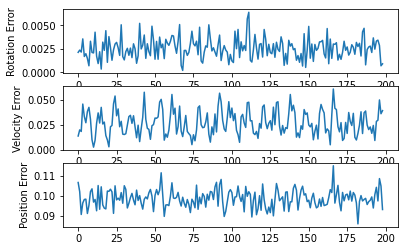

In [8]:
errR = []
errV = []
errP = []
for i in range(len(rel_pose3)):
    state_j = quad1_state[(i+1) * kf_steps]
    state_i = quad1_state[i*kf_steps]
    state_ij = rel_pose3[i]
    
    R = vee(logm(state_ij.Ri_from_b.T @ state_i.Ri_from_b.T @ state_j.Ri_from_b))
    errR.append(np.linalg.norm(R))
    
    term1 = state_i.Ri_from_b @ (state_j.v_i - state_i.v_i - g * Ts)
    v = term1 - state_ij.v_i
    errV.append(np.linalg.norm(v))
    
    term2 = state_i.Ri_from_b @ (state_j.p_i - state_i.p_i - Ts * state_i.v_i - Ts**2/2 * g)
    p = term2 - state_ij.p_i
    errP.append(np.linalg.norm(p))

# print(np.min(errP))
idx = np.arange(0, len(errR), 1)
fig, ax = plt.subplots(3, 1)
ax[0].plot(idx, errR)
ax[0].set_ylabel("Rotation Error")
ax[1].plot(idx, errV)
ax[1].set_ylabel("Velocity Error")
ax[2].plot(idx, errP) #What is with the weird jumps
ax[2].set_ylabel("Position Error")
plt.show()
